In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib import style
import os
import seaborn as sns
sns.set()

# Inputs

In [2]:
# filename = r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\all_data\Test Run 32 04-12-21 15 31 31 PM\DAQ- Crosshead, … - (Timed).csv"
# dimension_file = r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv"
# load_v_ext_dest_path = r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\NANONB-185L-4_6\load_v_extension.png"
# stress_v_strain_dest_path = r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\NANONB-185L-4_6\Stress_v_Strain.png"
# master_df_dest_path = r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\NANONB-185L-4_6\output_array.csv"
# confusion_matrix_dest_path = r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\NANONB-185L-4_6\confusion_matrix.csv"

In [3]:
def dimension(specimen_name, sample_number, dimension_file):

    specimen_name = specimen_name
    sample_number = sample_number

    dimension = pd.read_csv(dimension_file, header=[0,1])
    dfd = pd.DataFrame(dimension)

    gauge = 20
    thickness = dfd[specimen_name]['ThickAvg(mm)'][sample_number]
    width = dfd[specimen_name]['WidthAvg(mm)'][sample_number]
    return [dfd, gauge, thickness, width]

# DataCleaning Functions

In [31]:
def data_parser(filename, master_df_dest_path, gauge, thickness, width):
    #import and parsing
    with open(filename,'r') as read_obj:
        csv_reader = csv.reader(read_obj)
     #init empty arrays
        outputArray = []
        mm = []
        N = []
     #Are we cataloging?
        catalog = False
        for row in csv_reader:
            if len(row) != 3:
                catalog = False
            if catalog == True:
                #appending to our lists
                mm.append((float(row[0])))
                N.append((float(row[1])))
            if row[0] == 'mm': #begin cataloging entries
                catalog = True
            if (catalog == False) and (len(mm) != 0) and row[0] == 'DAQ: Crosshead, … - (Timed)   ':
                toappend = [np.asarray(mm), np.asarray(N)]
                outputArray.append(toappend)
                #reset for new array
                mm = [mm[-1]]
                N = [N[-1]]
        outputArray.append([np.asarray(mm),np.asarray(N)])
    #find stress v. strain and append to df
        extension = outputArray[0][0]
        load = outputArray[0][1]
        
        strain_values = extension/gauge
        stress_values = load/thickness/width

        df = pd.DataFrame()
        df['Extension (mm)'] = extension
        df['Load (N)'] = load
        df['Strain (mm/mm)'] = strain_values 
        df['Stress (MPa)'] = stress_values
        print(strain_values, stress_values)
    #clean dataframe (df) to drop the negatively sloped tail of the dataset
        for i in range(len(df)):
            if df['Stress (MPa)'][i] < 0.5 and i > 1000:
                df = df[:i]
                break
#         output master df to csv
        df.to_csv(master_df_dest_path)
    
        return df

In [5]:
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

In [49]:
def confusion_mat(df, confusion_matrix_dest_path, stress_v_strain_dest_path):
#calculate energy(area under the curve)
    energy = np.trapz(df['Stress (MPa)'], df['Strain (mm/mm)'], dx=0.00001)
#ultimate tensile strength and associated strain
    ult_stress = df['Stress (MPa)'].max()
    ult_stress_index = (getIndexes(df, ult_stress))[0][0]
    strain_at_ult_stress = df['Strain (mm/mm)'].loc[ult_stress_index]
#failure stress and associated strain
    for i in range(len(df['Stress (MPa)'])):
        delta = df['Stress (MPa)'][i] - df['Stress (MPa)'][i+1]
        if delta > 0.1 and df['Stress (MPa)'][i] > (max(df['Stress (MPa)']))*(0.80):
            index = getIndexes(df, df['Stress (MPa)'][i])[0][0]
            fail_stress = df['Stress (MPa)'][index]
            fail_strain = df['Strain (mm/mm)'][index]
            break
#MODULUS
    #chop off the first bunch of unclean data points
    index_list = [] 
    for i in range(len(df)):
    #find all the data points that are around 0 stress
        if df['Stress (MPa)'][i] < 0.05 or df['Load (N)'][i] < 0:
    #drop off all the data points that meet the corect index
            index_list.append(i)
            if i > 500:
                break
            max_index = max(index_list)
            df_nohead = df[max_index+1:]   
            df_nohead = df_nohead.reset_index()
        else:
            df_nohead = df.copy()
            max_index = 0

    def slope(df_nohead):
        slopes = []
        for i in range(1,len(df_nohead)):
            if df_nohead['Strain (mm/mm)'][i] >= 0.003:
                slope = (linregress(df['Strain (mm/mm)'][:i], df['Stress (MPa)'][:i]).slope)
                slopes.append(slope)  
        slopes = pd.DataFrame(slopes)
        return slopes
    print(df_nohead[:40])
    mod_mat = pd.DataFrame(slope(df_nohead))
    mod_mat['Modulus'] = mod_mat
    modulus = max(mod_mat['Modulus'])
#YIELD STRESS
#make a columns of all strain values shfited over by 0.2% (0.002 strain)
    df_shifted = df_nohead.copy()
    df_shifted['Strain (mm/mm)']= df_shifted['Strain (mm/mm)'] + 0.002 
    
#write a function that takes modulus and plugs in shifted 0.2%, computes a column of entries
    def f(df_shifted, modulus):
        shifted_stress = []
        for i in range(len(df_shifted)):
            stress = modulus*df_shifted['Strain (mm/mm)'][i]
            shifted_stress.append(stress)
        return shifted_stress
        
    df_shifted['Stress (MPa)'] = (f(df_shifted, modulus))   
    stress_deltas = []
    strain_deltas = []
    for i in range(len(df_shifted['Stress (MPa)'])):
        stress_delta = df['Stress (MPa)'][i] - df_shifted['Stress (MPa)'][i]
        strain_delta = df['Strain (mm/mm)'][i] - df_shifted['Strain (mm/mm)'][i]
        stress_deltas.append(stress_delta)
        strain_deltas.append(strain_delta)
    
    cumm_stress_diff = pd.DataFrame()
    cumm_stress_diff['stress difference'], cumm_stress_diff['strain difference'] = stress_deltas, strain_deltas

#the entry with the smallest difference between the shfited stress and the actual stresses
    for i in range(len(cumm_stress_diff)):
        if cumm_stress_diff['stress difference'][i] > cumm_stress_diff['stress difference'][i+1] and df_nohead['Strain (mm/mm)'][i] >= 0.005:
            yield_stress = df['Stress (MPa)'][i]
            yield_strain = df['Strain (mm/mm)'][i]
            break
    
# plot the stress v strain    
    plt.scatter(df['Strain (mm/mm)'], df['Stress (MPa)'])
#plot the modulus section overlay
    plt.scatter(df_shifted['Strain (mm/mm)'][:max_index+1], df_shifted['Stress (MPa)'][:max_index+1])
    plt.xlabel('Strain (mm/mm)')
    plt.ylabel('Stress (MPa)')
    plt.title('Stress vs. Strain')

# calculate confusion matrix
    confusion_mat = pd.DataFrame()
    confusion_mat['Modulus'] = [modulus]
    confusion_mat['Yield Stress (MPa)'] = [yield_stress]
    confusion_mat['Yield Strain (mm/mm)'] = [yield_strain]
    confusion_mat['Ultimate Stress (MPa)'] = ult_stress
    confusion_mat['Strain (mm/mm) at Ultimate Stress'] = [strain_at_ult_stress]
    confusion_mat['Failure Stress (MPa)'] = [fail_stress]
    confusion_mat['Failure Strain (mm/mm)'] = [fail_strain]
    confusion_mat['Energy--Ut--(J/m^3)'] = [energy]

    #output confusion matrix to csv
    confusion_mat.to_csv(confusion_matrix_dest_path)
    plt.savefig(stress_v_strain_dest_path, dpi = 300)
    print(confusion_mat)
    plt.show()
    return confusion_mat

## Plotting Code

In [7]:
def plot(plot_df, load_v_ext_dest_path):
    #plot #1 Load v. Extension
    plt.scatter(plot_df['Extension (mm)'], plot_df['Load (N)'])
    plt.xlabel('Extension (mm)')
    plt.ylabel('Label (N)')
    plt.title('Load vs. Extension')
    plt.savefig(load_v_ext_dest_path, dpi = 300)
    plt.show()
    #plot #2 Stres v. Strain
#     plt.plot(df['Strain (mm/mm)'], df['Stress (MPa)'])
#     plt.xlabel('Strain (mm/mm)')
#     plt.ylabel('Stress (MPa)')
#     plt.title('Stress vs. Strain')
#     plt.savefig(stress_v_strain_dest_path, dpi = 300)
#     plt.show()
    return

[1.22070318e-05 1.83105470e-05 4.27246107e-05 ... 5.49761951e-01
 5.49908448e-01 5.49969496e-01] [-0.07199525 -0.05269614 -0.04140168 ... 11.27690409  5.59407678
 -2.48835147]
    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0         0.000244 -0.036190        0.000012     -0.071995
1         0.000366 -0.026489        0.000018     -0.052696
2         0.000854 -0.020811        0.000043     -0.041402
3         0.002441 -0.011437        0.000122     -0.022752
4         0.006836  0.023688        0.000342      0.047125
5         0.016479  0.107061        0.000824      0.212985
6         0.030396  0.228181        0.001520      0.453942
7         0.038696  0.273367        0.001935      0.543833
8         0.043945  0.308839        0.002197      0.614401
9         0.047852  0.327342        0.002393      0.651211
10        0.052734  0.350987        0.002637      0.698249
11        0.057495  0.374782        0.002875      0.745588
12        0.061646  0.393640        0.003082      0.78310

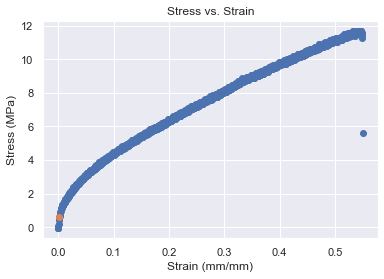

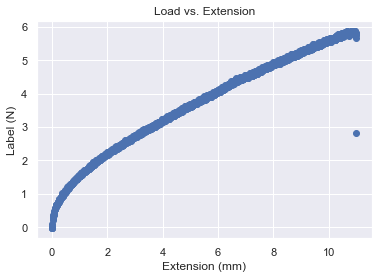

In [38]:
dimensions1 = dimension('ITI-4060-S2', 0, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df1 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\all_data\Test Run 40 04-12-21 15 31 32 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_1\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
confusion_mat1 = confusion_mat(df1, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_1\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_1\stress_v_strain.png")
plots1 = plot(df1, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_1\load_v_ext.png")

[0.00000000e+00 6.10351591e-06 1.83105470e-05 ... 5.61431888e-01
 5.61663834e-01 5.61822532e-01] [-0.05387264 -0.05504463 -0.04230234 ... 11.23155744  9.63395691
 -1.64832629]
    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0         0.000000 -0.027080        0.000000     -0.053873
1         0.000122 -0.027669        0.000006     -0.055045
2         0.000366 -0.021264        0.000018     -0.042302
3         0.001221 -0.011700        0.000061     -0.023275
4         0.003418 -0.005005        0.000171     -0.009957
5         0.012817  0.073371        0.000641      0.145963
6         0.026245  0.177457        0.001312      0.353032
7         0.037476  0.259280        0.001874      0.515808
8         0.043091  0.263706        0.002155      0.524614
9         0.046997  0.289498        0.002350      0.575925
10        0.052124  0.311492        0.002606      0.619680
11        0.056885  0.325472        0.002844      0.647491
12        0.061035  0.330776        0.003052      0.65804

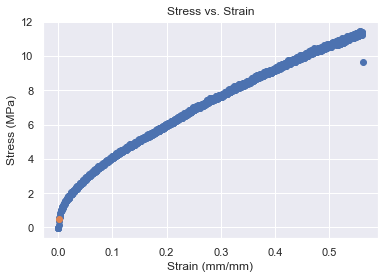

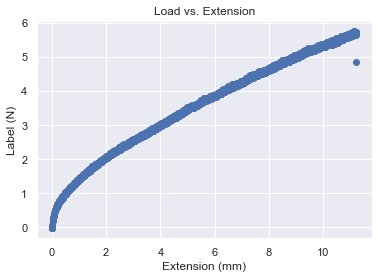

In [40]:
dimensions2 = dimension('ITI-4060-S2', 3, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df2 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\all_data\Test Run 41 04-12-21 15 31 32 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_2\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
confusion_mat2 = confusion_mat(df2, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_2\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_2\stress_v_strain.png")
plots2 = plot(df2, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_2\load_v_ext.png")

[0.00000000e+00 1.22070318e-05 2.44140637e-05 ... 7.26214610e-01
 7.26623554e-01 7.27001950e-01] [-0.05730373 -0.05466169 -0.04980466 ... 12.97586413 12.89366569
 -1.74115207]


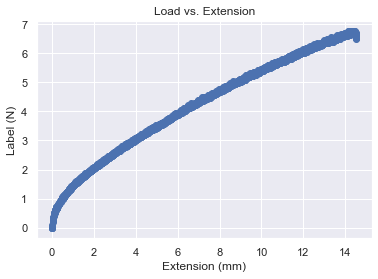

    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0         0.000000 -0.028805        0.000000     -0.057304
1         0.000244 -0.027477        0.000012     -0.054662
2         0.000488 -0.025035        0.000024     -0.049805
3         0.001587 -0.008319        0.000079     -0.016550
4         0.004639  0.013105        0.000232      0.026070
5         0.013916  0.085457        0.000696      0.170006
6         0.027222  0.176760        0.001361      0.351645
7         0.036865  0.245526        0.001843      0.488446
8         0.042480  0.273190        0.002124      0.543481
9         0.046387  0.281509        0.002319      0.560032
10        0.051392  0.307701        0.002570      0.612137
11        0.056152  0.317117        0.002808      0.630869
12        0.060425  0.337130        0.003021      0.670682
13        0.066406  0.365861        0.003320      0.727840
14        0.073120  0.384714        0.003656      0.765345
15        0.082642  0.431882        0.004132      0.8591

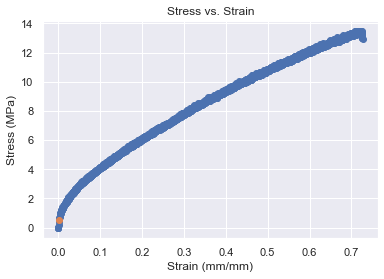

In [50]:
dimensions3 = dimension('ITI-4060-S2', 6, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df3 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\all_data\Test Run 42 04-12-21 15 31 32 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_3\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
plots3 = plot(df3, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_3\load_v_ext.png")
confusion_mat3 = confusion_mat(df3, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_3\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_3\stress_v_strain.png")

[0.00000000e+00 1.22070318e-05 2.44140637e-05 ... 7.07873516e-01
 7.08093261e-01 7.08172610e-01] [ 8.64194968e-03 -8.70588392e-03  1.12892535e-02 ...  1.54738483e+01
 -2.54125763e+00 -1.22815671e+00]


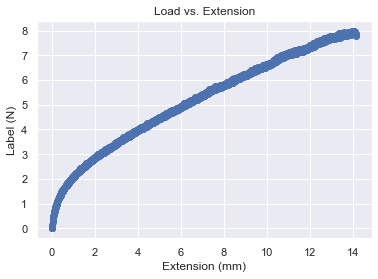

    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0         0.000000  0.004344        0.000000      0.008642
1         0.000244 -0.004376        0.000012     -0.008706
2         0.000488  0.005675        0.000024      0.011289
3         0.001709  0.017893        0.000085      0.035596
4         0.005127  0.043160        0.000256      0.085862
5         0.014282  0.125035        0.000714      0.248742
6         0.027466  0.243475        0.001373      0.484367
7         0.036743  0.316595        0.001837      0.629832
8         0.042236  0.351573        0.002112      0.699416
9         0.046143  0.370068        0.002307      0.736209
10        0.051147  0.394228        0.002557      0.784274
11        0.056152  0.436637        0.002808      0.868642
12        0.060547  0.437655        0.003027      0.870667
13        0.066406  0.481946        0.003320      0.958779
14        0.072876  0.520970        0.003644      1.036412
15        0.082275  0.571261        0.004114      1.1364

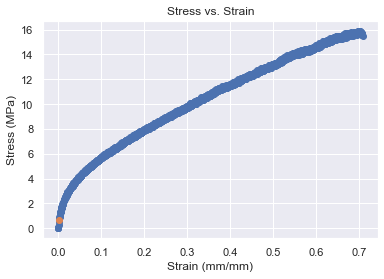

In [51]:
dimensions4 = dimension('ITI-4060-S2', 9, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df4 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\all_data\Test Run 43 04-12-21 15 31 32 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_4\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
plots4 = plot(df4, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_4\load_v_ext.png")
confusion_mat4 = confusion_mat(df4, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_4\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_4\stress_v_strain.png")

[6.10351591e-06 1.22070318e-05 3.05175774e-05 ... 6.09460426e-01
 6.09851070e-01 6.10095216e-01] [-0.05736952 -0.0498347  -0.06008042 ... 13.52649057 -4.04187033
 -2.46193373]


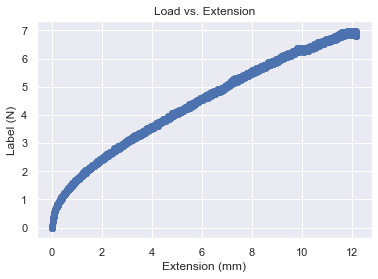

    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0         0.000122 -0.028838        0.000006     -0.057370
1         0.000244 -0.025050        0.000012     -0.049835
2         0.000610 -0.030200        0.000031     -0.060080
3         0.001709 -0.019627        0.000085     -0.039046
4         0.004761  0.010697        0.000238      0.021280
5         0.013794  0.085488        0.000690      0.170068
6         0.026855  0.207932        0.001343      0.413658
7         0.036865  0.289452        0.001843      0.575833
8         0.042725  0.308331        0.002136      0.613391
9         0.046753  0.338420        0.002338      0.673249
10        0.051880  0.348462        0.002594      0.693226
11        0.056641  0.368809        0.002832      0.733705
12        0.060913  0.389105        0.003046      0.774081
13        0.066650  0.420364        0.003333      0.836268
14        0.073120  0.453325        0.003656      0.901840
15        0.082642  0.503126        0.004132      1.0009

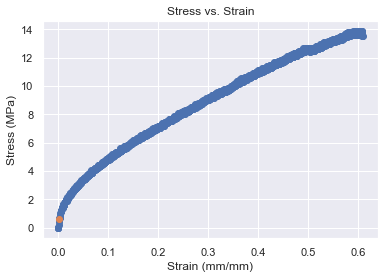

In [54]:
dimensions5 = dimension('ITI-4060-S2', 12, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df5 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\all_data\Test Run 44 04-12-21 15 31 32 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_5\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
plots5 = plot(df5, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_5\load_v_ext.png")
confusion_mat5 = confusion_mat(df5, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_5\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_5\stress_v_strain.png")

[0.00000000e+00 1.22070318e-05 2.44140637e-05 ... 6.70587178e-01
 6.71044923e-01 6.71423320e-01] [ 1.26189524e-02 -1.72372072e-03 -2.32169593e-03 ...  1.22428551e+01
  1.21201441e+01 -2.31562669e+00]


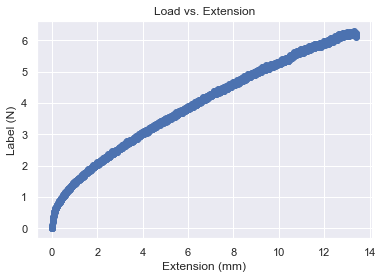

    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0         0.000000  0.006343        0.000000      0.012619
1         0.000244 -0.000866        0.000012     -0.001724
2         0.000488 -0.001167        0.000024     -0.002322
3         0.001709  0.004340        0.000085      0.008635
4         0.005005  0.023079        0.000250      0.045914
5         0.013916  0.104553        0.000696      0.207997
6         0.026489  0.207719        0.001324      0.413234
7         0.036499  0.262446        0.001825      0.522108
8         0.042603  0.298657        0.002130      0.594145
9         0.046753  0.330631        0.002338      0.657753
10        0.051758  0.333752        0.002588      0.663963
11        0.056641  0.362792        0.002832      0.721735
12        0.060913  0.374209        0.003046      0.744448
13        0.066650  0.399769        0.003333      0.795296
14        0.073242  0.425594        0.003662      0.846673
15        0.082642  0.466341        0.004132      0.9277

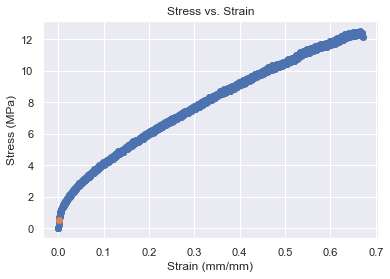

In [55]:
dimensions6 = dimension('ITI-4060-S2', 15, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df6 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\all_data\Test Run 45 04-12-21 15 31 32 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_6\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
plots6 = plot(df6, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_6\load_v_ext.png")
confusion_mat6 = confusion_mat(df6, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_6\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\ITI-4060-S2_6\stress_v_strain.png")

    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0         0.000122  0.000591        0.000006      0.004602
1         0.000122  0.004211        0.000006      0.032797
2         0.000122  0.011228        0.000006      0.087452
3         0.000244  0.019133        0.000012      0.149015
4         0.000610  0.005887        0.000031      0.045847
5         0.003174  0.028193        0.000159      0.219578
6         0.021729  0.157962        0.001086      1.230270
7         0.039673  0.298155        0.001984      2.322147
8         0.045044  0.334368        0.002252      2.604187
9         0.048706  0.352288        0.002435      2.743753
10        0.052856  0.373003        0.002643      2.905094
11        0.058228  0.398920        0.002911      3.106942
12        0.062622  0.416064        0.003131      3.240468
13        0.067749  0.445440        0.003387      3.469261
14        0.073364  0.467745        0.003668      3.642978
15        0.082397  0.509116        0.004120      3.9651

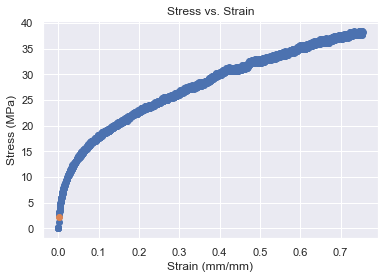

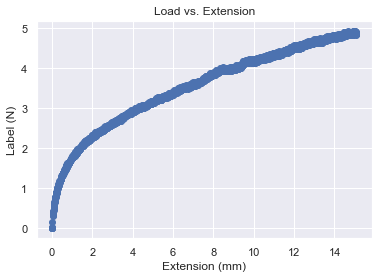

In [15]:
dimensions7 = dimension('CNPU-181L-2', 18, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df7 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\Test Run 8 04-9-21 16 09 57 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-2_7\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
confusion_mat7 = confusion_mat(df7, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-2_7\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-2_7\stress_v_strain.png")
plots7 = plot(df7, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-2_7\load_v_ext.png")

    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0         0.000122 -0.020663        0.000006     -0.160934
1         0.000122 -0.022856        0.000006     -0.178015
2         0.000122 -0.014440        0.000006     -0.112468
3         0.000122 -0.021567        0.000006     -0.167974
4         0.000366 -0.022100        0.000018     -0.172125
5         0.002808 -0.001240        0.000140     -0.009658
6         0.023071  0.138304        0.001154      1.077165
7         0.039551  0.260526        0.001978      2.029079
8         0.045166  0.298427        0.002258      2.324264
9         0.048828  0.308586        0.002441      2.403391
10        0.053223  0.327864        0.002661      2.553532
11        0.058472  0.349794        0.002924      2.724334
12        0.062622  0.364000        0.003131      2.834974
13        0.067383  0.376919        0.003369      2.935590
14        0.072876  0.409163        0.003644      3.186721
15        0.081909  0.452969        0.004095      3.5278

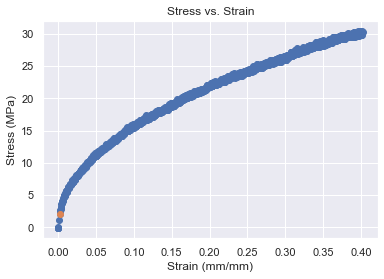

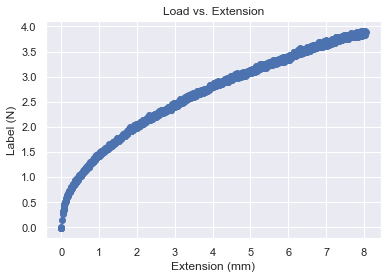

In [16]:
dimensions4_1 = dimension('CNPU-181L-4', 0, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df4_1 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\Test Run 9 04-9-21 16 09 57 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_1\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
confusion_mat4_1 = confusion_mat(df4_1, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_1\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_1\stress_v_strain.png")
plots4_1 = plot(df4_1, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_1\load_v_ext.png")

    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0         0.000000 -0.008949        0.000000     -0.069696
1         0.000000 -0.010669        0.000000     -0.083091
2         0.000122 -0.007540        0.000006     -0.058727
3         0.000244 -0.011598        0.000012     -0.090332
4         0.000854 -0.016504        0.000043     -0.128542
5         0.005005 -0.000470        0.000250     -0.003663
6         0.026001  0.004122        0.001300      0.032100
7         0.039429  0.007861        0.001971      0.061226
8         0.044556  0.005535        0.002228      0.043110
9         0.048340  0.001138        0.002417      0.008860
10        0.052734  0.000815        0.002637      0.006349
11        0.057861  0.008353        0.002893      0.065053
12        0.062256  0.016005        0.003113      0.124657
13        0.067139  0.025474        0.003357      0.198401
14        0.072998  0.047323        0.003650      0.368567
15        0.082764  0.110870        0.004138      0.8634

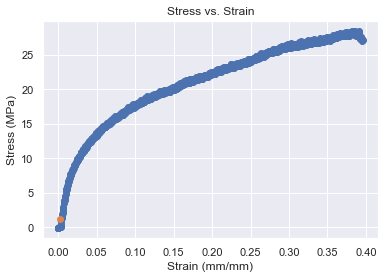

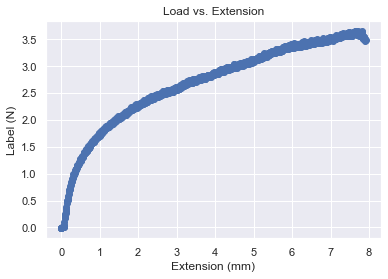

In [17]:
dimensions4_2 = dimension('CNPU-181L-4', 3, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df4_2 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\Test Run 10 04-9-21 16 09 57 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_2\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
confusion_mat4_2 = confusion_mat(df4_2, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_2\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_2\stress_v_strain.png")
plots4_2 = plot(df4_2, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_2\load_v_ext.png")

    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0         0.000122 -0.000176        0.000006     -0.001373
1         0.000122 -0.006400        0.000006     -0.049845
2         0.000122 -0.011773        0.000006     -0.091690
3         0.000244 -0.001578        0.000012     -0.012287
4         0.001099  0.000869        0.000055      0.006766
5         0.008301  0.052533        0.000415      0.409144
6         0.029907  0.201100        0.001495      1.566242
7         0.040039  0.284495        0.002002      2.215757
8         0.044678  0.303853        0.002234      2.366526
9         0.048340  0.317115        0.002417      2.469812
10        0.052734  0.336783        0.002637      2.622996
11        0.057739  0.366235        0.002887      2.852379
12        0.061890  0.385882        0.003094      3.005397
13        0.066650  0.420474        0.003333      3.274816
14        0.071777  0.443561        0.003589      3.454629
15        0.080566  0.484899        0.004028      3.7765

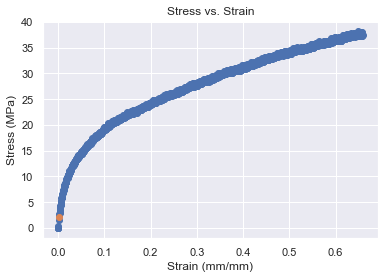

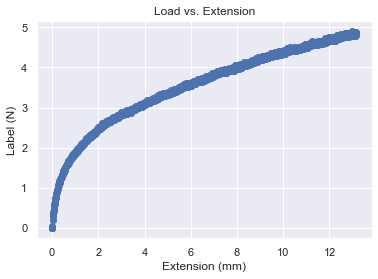

In [18]:
dimensions4_3 = dimension('CNPU-181L-4', 6, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df4_3 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\Test Run 11 04-9-21 16 09 57 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_3\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
confusion_mat4_3 = confusion_mat(df4_3, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_3\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_3\stress_v_strain.png")
plots4_3 = plot(df4_3, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_3\load_v_ext.png")

    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0         0.000000 -0.063696        0.000000     -0.496091
1         0.000122 -0.062809        0.000006     -0.489180
2         0.000122 -0.055777        0.000006     -0.434416
3         0.000244 -0.056139        0.000012     -0.437230
4         0.000732 -0.057949        0.000037     -0.451330
5         0.003174 -0.052357        0.000159     -0.407776
6         0.020874  0.086107        0.001044      0.670634
7         0.039062  0.204308        0.001953      1.591229
8         0.045166  0.231417        0.002258      1.802368
9         0.048950  0.241722        0.002448      1.882627
10        0.052979  0.256353        0.002649      1.996575
11        0.057983  0.272177        0.002899      2.119818
12        0.062378  0.297883        0.003119      2.320028
13        0.067017  0.299825        0.003351      2.335151
14        0.072510  0.339141        0.003625      2.641359
15        0.081299  0.367815        0.004065      2.8646

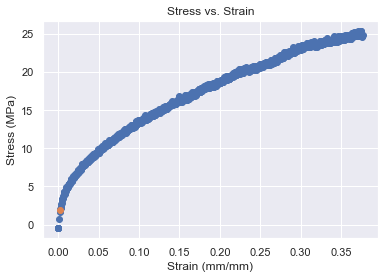

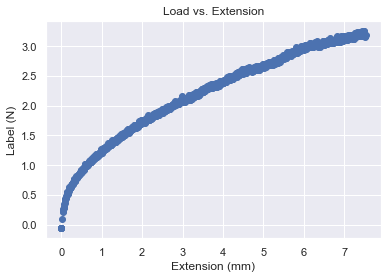

In [19]:
dimensions4_4 = dimension('CNPU-181L-4', 9, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df4_4 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\Test Run 12 04-9-21 16 09 57 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_4\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
confusion_mat4_4 = confusion_mat(df4_4, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_4\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_4\stress_v_strain.png")
plots4_4 = plot(df4_4, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_4\load_v_ext.png")

In [23]:
#data is corrupted
dimensions4_5 = dimension('CNPU-181L-4', 12, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df4_5 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\Test Run 13 04-9-21 16 09 57 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_5\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
confusion_mat4_5 = confusion_mat(df4_5, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_5\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_5\stress_v_strain.png")
plots4_5 = plot(df4_5, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_5\load_v_ext.png")

[] []


IndexError: index -1 is out of bounds for axis 0 with size 0

[0.00000000e+00 0.00000000e+00 6.10351591e-06 ... 2.82189948e-01
 2.82568368e-01 2.82659917e-01] [ 0.14248041  0.07143922  0.04096545 ... 20.21758912  7.61352688
 -1.37276315]
      Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0           0.000000  0.018294        0.000000      0.142480
1           0.000000  0.009173        0.000000      0.071439
2           0.000122  0.005260        0.000006      0.040965
3           0.000244 -0.005371        0.000012     -0.041828
4           0.001465  0.012826        0.000073      0.099897
...              ...       ...             ...           ...
1013        5.574341  3.611254        0.278717     28.125856
1014        5.581787  3.619626        0.279089     28.191059
1015        5.592285  3.661155        0.279614     28.514501
1016        5.599976  3.654966        0.279999     28.466296
1017        5.604614  3.629152        0.280231     28.265252

[1018 rows x 4 columns]
    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0       

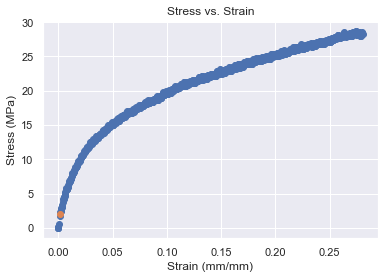

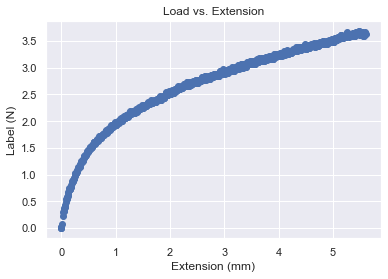

In [24]:
dimensions4_6 = dimension('CNPU-181L-4', 15, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df4_6 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\Test Run 14 04-9-21 16 09 57 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_6\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
confusion_mat4_6 = confusion_mat(df4_6, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_6\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_6\stress_v_strain.png")
plots4_6 = plot(df4_6, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_6\load_v_ext.png")

[0.00000000e+00 6.10351591e-06 6.10351591e-06 ... 5.15093980e-01
 5.15655521e-01 5.15795918e-01] [-0.08212464 -0.06176203 -0.04898038 ... 32.89917819 -2.35733135
  0.13524927]
      Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0           0.000000 -0.010544        0.000000     -0.082125
1           0.000122 -0.007930        0.000006     -0.061762
2           0.000122 -0.006289        0.000006     -0.048980
3           0.000244 -0.001483        0.000012     -0.011552
4           0.000854 -0.009247        0.000043     -0.072022
...              ...       ...             ...           ...
1868       10.279053  4.238982        0.513953     33.014841
1869       10.283081  4.233681        0.514154     32.973558
1870       10.288452  4.203182        0.514423     32.736016
1871       10.294922  4.218657        0.514746     32.856540
1872       10.301880  4.224131        0.515094     32.899178

[1873 rows x 4 columns]
    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0       

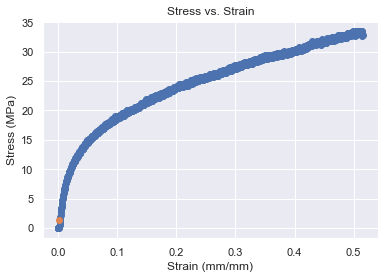

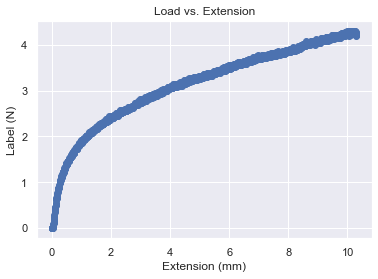

In [26]:
dimensions4_7 = dimension('CNPU-181L-4', 18, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df4_7 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\Test Run 15 04-9-21 16 09 57 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_7\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
confusion_mat4_7 = confusion_mat(df4_7, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_7\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_7\stress_v_strain.png")
plots4_7 = plot(df4_7, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_7\load_v_ext.png")

[0.         0.         0.         ... 0.4269104  0.4271179  0.42727049] [ 1.97427728e-02  2.25964840e-02  4.95169353e-03 ...  3.17464353e+01
  2.93518109e+01 -2.77820953e+00]
      Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0           0.000000  0.002535        0.000000      0.019743
1           0.000000  0.002901        0.000000      0.022596
2           0.000000  0.000636        0.000000      0.004952
3           0.000122 -0.004955        0.000006     -0.038594
4           0.000366  0.014994        0.000018      0.116782
...              ...       ...             ...           ...
1547        8.511352  4.116628        0.425568     32.061903
1548        8.516723  4.114539        0.425836     32.045633
1549        8.522583  4.121865        0.426129     32.102692
1550        8.531372  4.134005        0.426569     32.197238
1551        8.538208  4.076123        0.426910     31.746435

[1552 rows x 4 columns]
    Extension (mm)  Load (N)  Strain (mm/mm)  Stress (MPa)
0        

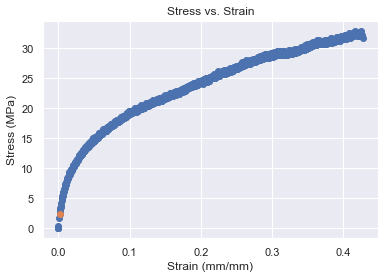

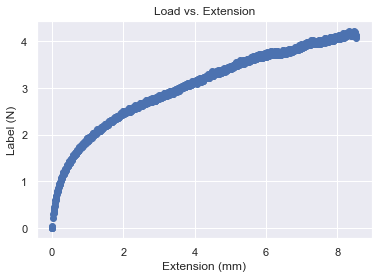

In [77]:
dimensions4_8 = dimension('CNPU-181L-4', 21, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\sample_dimensions.csv")
df4_8 = data_parser(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\Test Run 16 04-9-21 16 09 57 PM\DAQ- Crosshead, … - (Timed).csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_8\output_array.csv", dimensions1[1], dimensions1[2], dimensions1[3])
confusion_mat4_8 = confusion_mat(df4_8, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_8\confusion_mat.csv", r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_8\stress_v_strain.png")
plots4_8 = plot(df4_8, r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\TOTAL_DATA_EXPORT\CNPU-181L-4_8\load_v_ext.png")

## DF combiner code (append dataframes together)

In [27]:
df1

,Extension (mm),Load (N),Strain (mm/mm),Stress (MPa)
0,0.000000,0.001200,0.000000,0.009345
1,0.000000,-0.011145,0.000000,-0.086804
2,0.000122,-0.009519,0.000006,-0.074135
3,0.000610,0.013409,0.000031,0.104432
4,0.001831,-0.000266,0.000092,-0.002071
...,...,...,...,...
1524,8.386230,3.758314,0.419312,29.271212
1525,8.390869,3.758087,0.419543,29.269446
1526,8.395508,3.740631,0.419775,29.133492
1527,8.399658,3.737936,0.419983,29.112500


In [78]:
def df_combiner(df1, df2, df3, df4, df5, df6, df7, df4_1, df4_2, df4_3, df4_4, df4_6, df4_7, df4_8):
    dataframe_list = [df1, df2, df3, df4, df5, df6, df7, df4_1, df4_2, df4_3, df4_4, df4_6, df4_7, df4_8]
    cummulative_output_mat = pd.concat(dataframe_list, axis=1)
    columns =['Sample1','Sample1', 'Sample1', 'Sample1', 
                                     'Sample2','Sample2','Sample2','Sample2',
                                     'Sample3','Sample3','Sample3', 'Sample3', 
                                     'Sample4','Sample4', 'Sample4','Sample4', 
                                     'Sample5','Sample5', 'Sample5', 'Sample5', 
                                     'Sample6','Sample6', 'Sample6', 'Sample6',
                                     'Sample7','Sample7,', 'Sample7', 'Sample7',
                                     'Sample1','Sample1', 'Sample1', 'Sample1', 
                                     'Sample2','Sample2','Sample2','Sample2',
                                     'Sample3','Sample3','Sample3', 'Sample3', 
                                     'Sample4','Sample4', 'Sample4','Sample4', 
                                     'Sample6','Sample6', 'Sample6', 'Sample6',
                                     'Sample7','Sample7','Sample7','Sample7',
                                     'Sample8','Sample8','Sample8','Sample8',]
    cummulative_output_mat.columns = pd.MultiIndex.from_tuples(
    zip(['CNPU-181L-2', 'CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2','CNPU-181L-2',
         'CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4','CNPU-181L-4', 'CNPU-181L-4'],
    ['Sample1','Sample1', 'Sample1', 'Sample1', 
                                     'Sample2','Sample2','Sample2','Sample2',
                                     'Sample3','Sample3','Sample3', 'Sample3', 
                                     'Sample4','Sample4', 'Sample4','Sample4', 
                                     'Sample5','Sample5', 'Sample5', 'Sample5', 
                                     'Sample6','Sample6', 'Sample6', 'Sample6',
                                     'Sample7','Sample7', 'Sample7', 'Sample7',
                                     'Sample1','Sample1', 'Sample1', 'Sample1', 
                                     'Sample2','Sample2','Sample2','Sample2',
                                     'Sample3','Sample3','Sample3', 'Sample3', 
                                     'Sample4','Sample4', 'Sample4','Sample4', 
                                     'Sample6','Sample6', 'Sample6', 'Sample6',
                                      'Sample7','Sample7','Sample7','Sample7',
                                        'Sample8','Sample8','Sample8','Sample8',],
     ['Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
        'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
        'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
        'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
         'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
           'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',

     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',

      'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
      'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',

     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)']))
    
    
    return cummulative_output_mat

In [66]:
df = pd.read_csv(r"D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\all_data\iti_cummulative_output_array.csv", header=[0,1,2])
df

ITI-4060-S1                                                       \
            Sample1                                              Sample2   
     Extension (mm)  Load (N) Strain (mm/mm) Stress (MPa) Extension (mm)   
0          0.000000 -0.009892       0.000000    -0.071413       0.000000   
1          0.000122 -0.001965       0.000006    -0.014189       0.000122   
2          0.000488 -0.014987       0.000024    -0.108199       0.000488   
3          0.001587 -0.000085       0.000079    -0.000617       0.001587   
4          0.004883 -0.004708       0.000244    -0.033990       0.004883   
...             ...       ...            ...          ...            ...   
2637            NaN       NaN            NaN          NaN            NaN   
2638            NaN       NaN            NaN          NaN            NaN   
2639            NaN       NaN            NaN          NaN            NaN   
2640            NaN       NaN            NaN          NaN            NaN   
2641            NaN       NaN            NaN          NaN            NaN   

                                                                     ...  \
                                                  Sample3            ...   
      Load (N) Strain (mm/mm) Stress (MPa) Extension (mm)  Load (N)  ...   
0    -0.000758       0.000000    -0.005469       0.000000  0.002832  ...   
1    -0.001617       0.000006    -0.011677       0.000122 -0.003037  ...   
2     0.000219       0.000024     0.001582       0.000488 -0.004206  ...   
3     0.003183       0.000079     0.022981       0.001587 -0.001586  ...   
4    -0.009239       0.000244    -0.066702       0.004761 -0.008163  ...   
...        ...            ...          ...            ...       ...  ...   
2637       NaN            NaN          NaN            NaN       NaN  ...   
2638       NaN            NaN          NaN            NaN       NaN  ...   
2639       NaN            NaN          NaN            NaN       NaN  ...   
2640       NaN            NaN          NaN            NaN       NaN  ...   
2641       NaN            NaN          NaN            NaN       NaN  ...   

        ITI-4060-S2                                                       \
            Sample4                     Sample5                            
     Strain (mm/mm) Stress (MPa) Extension (mm)  Load (N) Strain (mm/mm)   
0          0.000000     0.008642       0.000122 -0.028838       0.000006   
1          0.000012    -0.008706       0.000244 -0.025050       0.000012   
2          0.000024     0.011289       0.000610 -0.030200       0.000030   
3          0.000085     0.035596       0.001709 -0.019627       0.000085   
4          0.000256     0.085862       0.004761  0.010697       0.000238   
...             ...          ...            ...       ...            ...   
2637            NaN          NaN            NaN       NaN            NaN   
2638            NaN          NaN            NaN       NaN            NaN   
2639            NaN          NaN            NaN       NaN            NaN   
2640            NaN          NaN            NaN       NaN            NaN   
2641            NaN          NaN            NaN       NaN            NaN   

                                                                        
                         Sample6                                        
     Stress (MPa) Extension (mm)  Load (N) Strain (mm/mm) Stress (MPa)  
0       -0.057370       0.000000  0.006343       0.000000     0.012619  
1       -0.049835       0.000244 -0.000866       0.000012    -0.001724  
2       -0.060080       0.000488 -0.001167       0.000024    -0.002322  
3       -0.039046       0.001709  0.004340       0.000085     0.008635  
4        0.021280       0.005005  0.023079       0.000250     0.045914  
...           ...            ...       ...            ...          ...  
2637          NaN            NaN       NaN            NaN          NaN  
2638          NaN            NaN       NaN            NaN          NaN  
2639      

In [103]:
def cummulative_stress_strain_plots(df, sample_name, cummulative_stress_strain_output):
    plt.plot(df[sample_name]['Sample1']['Strain (mm/mm)'][:1980], df[sample_name]['Sample1']['Stress (MPa)'][:1980], color = 'red', marker = 'o', markersize = 2, label = sample_name +' Sample 1')
    plt.plot(df[sample_name]['Sample2']['Strain (mm/mm)'][:1980], df[sample_name]['Sample2']['Stress (MPa)'][:1980], color = 'orange', marker = 'o', markersize = 2, label = sample_name +' Sample 2')
    plt.plot(df[sample_name]['Sample3']['Strain (mm/mm)'], df[sample_name]['Sample3']['Stress (MPa)'], color = 'goldenrod', marker = 'o', markersize = 2, label = sample_name +' Sample 3')
    plt.plot(df[sample_name]['Sample4']['Strain (mm/mm)'], df[sample_name]['Sample4']['Stress (MPa)'], color = 'lime', marker = 'o', markersize = 2, label = sample_name +' Sample 4')
    plt.plot(df[sample_name]['Sample5']['Strain (mm/mm)'], df[sample_name]['Sample5']['Stress (MPa)'], color = 'green', marker = 'o', markersize = 2, label = sample_name +' Sample 5')
    plt.plot(df[sample_name]['Sample6']['Strain (mm/mm)'], df[sample_name]['Sample6']['Stress (MPa)'], color = 'blue', marker = 'o', markersize = 2, label = sample_name +' Sample 6')

    plt.title(sample_name)
    plt.ylabel('Stress (MPa)')
    plt.xlabel('Strain (mm/mm)')
    plt.legend(loc=10, bbox_to_anchor=(1.3,0.5))
    plt.savefig(cummulative_stress_strain_output, dpi = 300, bbox_inches ='tight')
    plt.show()
    return

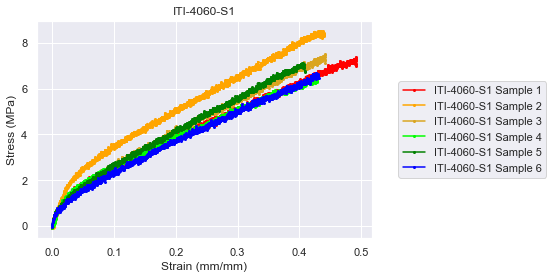

In [90]:
cummulative_stress_strain_plots(df, 'ITI-4060-S1', r'D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\all_data\cummulative_stress_strain-S1.png')


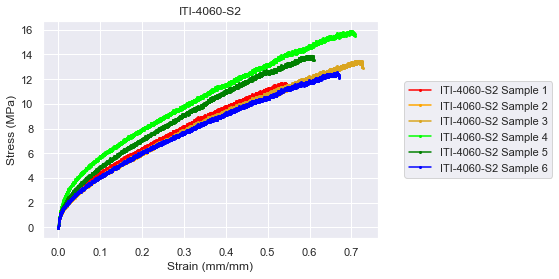

In [104]:
cummulative_stress_strain_plots(df, 'ITI-4060-S2', r'D:\National Research Council of Canada\YadienkaCNTResults\april_09_2021\APRIL12\all_data\cummulative_stress_strain-S2.png')


In [ ]:
def df_combiner(confusion_mat1, confusion_mat2, confusion_mat3, confusion_mat4, confusion_mat5, 
               confusion_mat6, confusion_mat7, confusion4_1, confusion_mat4_2, confusion_mat4_3, 
               confusion_mat4_4, confusion4_6):
    dataframe_list = [confusion_mat1, confusion_mat2, confusion_mat3, confusion_mat4, confusion_mat5, 
               confusion_mat6, confusion_mat7, confusion4_1, confusion_mat4_2, confusion_mat4_3, 
               confusion_mat4_4, confusion4_6]
    cummulative_output_mat = pd.concat(dataframe_list, axis=1)
    columns =['Sample1','Sample1', 'Sample1', 'Sample1', 
                                     'Sample2','Sample2','Sample2','Sample2',
                                     'Sample3','Sample3','Sample3', 'Sample3', 
                                     'Sample4','Sample4', 'Sample4','Sample4', 
                                     'Sample5','Sample5', 'Sample5', 'Sample5', 
                                     'Sample6','Sample6', 'Sample6', 'Sample6',
                                     'Sample7','Sample7,', 'Sample7', 'Sample7',
                                     'Sample1','Sample1', 'Sample1', 'Sample1', 
                                     'Sample2','Sample2','Sample2','Sample2',
                                     'Sample3','Sample3','Sample3', 'Sample3', 
                                     'Sample4','Sample4', 'Sample4','Sample4', 
                                     'Sample5','Sample5', 'Sample5', 'Sample5', 
                                     'Sample6','Sample6', 'Sample6', 'Sample6',]
    cummulative_output_mat.columns = pd.MultiIndex.from_tuples(
    zip(['', 'NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3','NANONB-3', 
        'NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4','NANONB-4'] ,
    ['Sample1','Sample1', 'Sample1', 'Sample1', 
                                     'Sample2','Sample2','Sample2','Sample2',
                                     'Sample3','Sample3','Sample3', 'Sample3', 
                                     'Sample4','Sample4', 'Sample4','Sample4', 
                                     'Sample5','Sample5', 'Sample5', 'Sample5', 
                                     'Sample6','Sample6', 'Sample6', 'Sample6',
                                     'Sample7','Sample7', 'Sample7', 'Sample7',
                                     'Sample1','Sample1', 'Sample1', 'Sample1', 
                                     'Sample2','Sample2','Sample2','Sample2',
                                     'Sample3','Sample3','Sample3', 'Sample3', 
                                     'Sample4','Sample4', 'Sample4','Sample4', 
                                     'Sample5','Sample5', 'Sample5', 'Sample5', 
                                     'Sample6','Sample6', 'Sample6', 'Sample6',],
    ['Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
        'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
        'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
        'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
         'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)',
     'Extension (mm)', 'Load (N)', 'Strain (mm/mm)','Stress (MPa)']))
    
    
    return cummulative_output_mat

## master df

## do this once we have multiple datasets to combine

### confusion matrix